# Trade-off between classification accuracy and reconstruction error during dimensionality reduction

- Low-dimensional LSTM representations are excellent at dimensionality reduction, but are poor at reconstructing the original data
- On the other hand, PCs are excellent at reconstructing the original data but these high-variance components do not preserve class information

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pickle
import os
import random
import sys

# visualizations
from _plotly_future_ import v4_subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.express as px
pio.templates.default = 'plotly_white'
pio.orca.config.executable = '/home/joyneelm/fire/bin/orca'
colors = px.colors.qualitative.Plotly

In [2]:
class ARGS():
    roi = 300
    net = 7
    subnet = 'wb'
    train_size = 100
    batch_size = 32
    num_epochs = 50
    zscore = 1
    
    #gru
    k_hidden = 32
    k_layers = 1
    dims = [3, 4, 5, 10]

In [3]:
args = ARGS()

In [4]:
def _get_results(k_dim):
    
    RES_DIR = 'results/clip_gru_recon'
    load_path = (RES_DIR + 
        '/roi_%d_net_%d' %(args.roi, args.net) + 
        '_trainsize_%d' %(args.train_size) +
        '_k_hidden_%d' %(args.k_hidden) +
        '_kdim_%d' %(k_dim) +
        '_k_layers_%d' %(args.k_layers) +
        '_batch_size_%d' %(args.batch_size) +
        '_num_epochs_45' +
        '_z_%d.pkl' %(args.zscore))
    
    with open(load_path, 'rb') as f:
        results = pickle.load(f)
#     print(results.keys())
    return results

In [5]:
r = {}
for k_dim in args.dims:
    r[k_dim] = _get_results(k_dim)

In [6]:
def _plot_fig(ss):
    
    title_text = ss
    if ss=='var':
        ss = 'mse'
        invert = True
    else:
        invert = False
    
    subplot_titles = ['train', 'test']
    fig = tls.make_subplots(rows=1, 
                            cols=2, 
                            subplot_titles=subplot_titles,
                            print_grid=False)

    for ii, x in enumerate(['train', 'test']):
        gru_score = {'mean':[], 'ste':[]}
        pca_score = {'mean':[], 'ste':[]}
        for k_dim in args.dims:

            a = r[k_dim]
            
            # gru decoder
            y = np.mean(a['%s_%s'%(x, ss)])
            gru_score['mean'].append(y)
            
            # pca decoder
            y = np.mean(a['%s_pca_%s'%(x, ss)])
            pca_score['mean'].append(y)
            
        x = np.arange(len(args.dims))
        if invert:
            y = 1 - np.array(gru_score['mean'])
        else:
            y = gru_score['mean']
        error_y = gru_score['ste']
        trace = go.Bar(x=x, y=y,
                       name='lstm decoder',
                       marker_color=colors[0])
        fig.add_trace(trace, 1, ii+1)

        if invert:
            y = 1 - np.array(pca_score['mean'])
        else:
            y = pca_score['mean']
        error_y = pca_score['ste']
        trace = go.Bar(x=x, y=y,
                       name='pca recon',
                       marker_color=colors[1])
        fig.add_trace(trace, 1, ii+1)

    fig.update_xaxes(tickvals=np.arange(len(args.dims)),
                     ticktext=args.dims)
    fig.update_layout(height=350, width=700,
                      title_text=title_text)
    
    return fig

## Mean-squared error vs number of dimensions

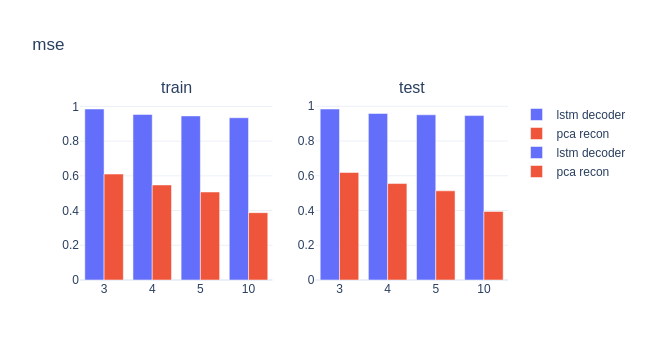

In [7]:
'''
mse
'''
ss = 'mse'
fig = _plot_fig(ss)
fig.show()

## Variance captured vs number of dimensions

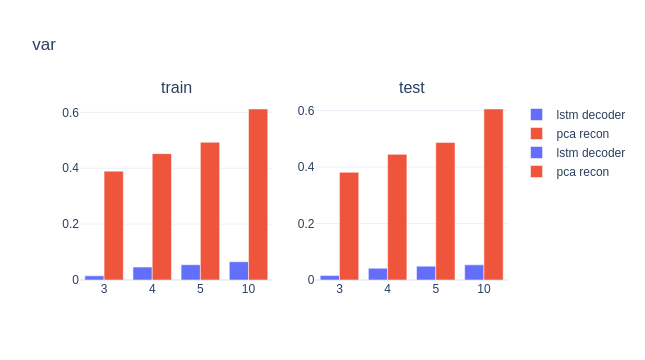

In [8]:
'''
variance
'''
ss = 'var'
fig = _plot_fig(ss)
fig.show()

## R-squared vs number of dimensions

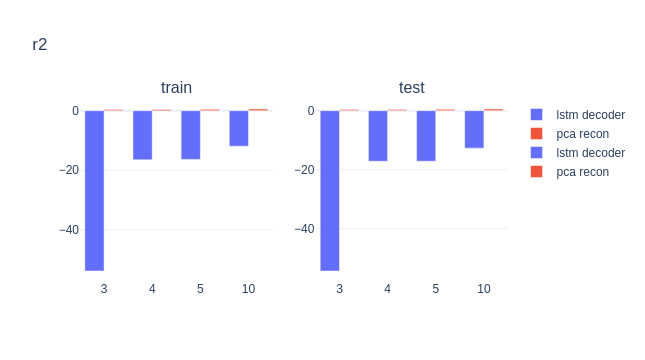

In [9]:
'''
r2
'''
ss = 'r2'
fig = _plot_fig(ss)
fig.show()

In [10]:
results = r[10]

# variance not captured by pca recon
pca_not = 1 - np.sum(results['pca_var'])
print('percent variance captured by pca components = %0.3f' %(1 - pca_not))
# this is proportional to pca mse
pca_mse = results['test_pca_mse']

# variance not captured by lstm decoder?
lstm_mse = results['test_mse']

lstm_not = lstm_mse*(pca_not/pca_mse)
print('percent variance captured by lstm recon = %0.3f' %(1 - lstm_not))

percent variance captured by pca components = 0.611
percent variance captured by lstm recon = 0.067


In [11]:
def _plot_fig_ext(ss):
    
    title_text = ss
    if ss=='var':
        ss = 'mse'
        invert = True
    else:
        invert = False
    
    subplot_titles = ['train', 'test']
    fig = go.Figure()

    x = 'test'
    
    lstm_score = {'mean':[], 'ste':[]}
    pca_score = {'mean':[], 'ste':[]}
    lstm_acc = {'mean':[], 'ste':[]}
    pc_acc = {'mean':[], 'ste':[]}
    for k_dim in args.dims:

        a = r[k_dim]
        # lstm encoder
        k_sub = len(a['test'])
        y = np.mean(a['test'])
        error_y = 3/np.sqrt(k_sub)*np.std(a['test'])
        lstm_acc['mean'].append(y)
        lstm_acc['ste'].append(error_y)

        # lstm decoder
        y = np.mean(a['%s_%s'%(x, ss)])
        lstm_score['mean'].append(y)
        lstm_score['ste'].append(error_y)

        # pca encoder
        b = r_pc[k_dim]
        y = np.mean(b['test'])
        error_y = 3/np.sqrt(k_sub)*np.std(b['test'])
        pc_acc['mean'].append(y)
        pc_acc['ste'].append(error_y)

        # pca decoder
        y = np.mean(a['%s_pca_%s'%(x, ss)])
        pca_score['mean'].append(y)
        pca_score['ste'].append(error_y)

    x = np.arange(len(args.dims))

    y = lstm_acc['mean']
    error_y = lstm_acc['ste']
    trace = go.Bar(x=x, y=y,
                   name='GRU Accuracy',
                   error_y=dict(type='data',
                                array=error_y),
                   marker_color=colors[3])
    fig.add_trace(trace)

    y = pc_acc['mean']
    error_y = pc_acc['ste']
    trace = go.Bar(x=x, y=y,
                   name='PCA Accuracy',
                   error_y=dict(type='data',
                                array=error_y),
                   marker_color=colors[4])
    fig.add_trace(trace)
    
    if invert:
        y = 1 - np.array(lstm_score['mean'])
    else:
        y = lstm_score['mean']
    error_y = lstm_score['ste']
    trace = go.Bar(x=x, y=y,
                   name='GRU Reconstruction',
                   error_y=dict(type='data',
                                array=error_y),
                   marker_color=colors[5])
    fig.add_trace(trace)

    if invert:
        y = 1 - np.array(pca_score['mean'])
    else:
        y = pca_score['mean']
    error_y = pca_score['ste']
    trace = go.Bar(x=x, y=y,
                   name='PCA Reconstruction',
                   error_y=dict(type='data', 
                                array=error_y),
                   marker_color=colors[2])
    fig.add_trace(trace)
    fig.update_yaxes(title=dict(text='Accuracy or % variance',
                                font_size=20),
                     gridwidth=1, gridcolor='#bfbfbf',
                     tickfont=dict(size=20))
    fig.update_xaxes(title=dict(text='Number of dimensions',
                                font_size=20),
                     tickvals=np.arange(len(args.dims)),
                     ticktext=args.dims,
                     tickfont=dict(size=20))
    fig.update_layout(height=470, width=570,
                      font_color='black',
                      legend_orientation='h',
                      legend_font_size=20,
                      legend_x=-0.1,
                      legend_y=-0.3)
    
    return fig

In [12]:
def _get_pc_results(PC_DIR, k_dim):
    load_path = (PC_DIR + 
        '/roi_%d_net_%d' %(args.roi, args.net) + 
        '_nw_%s' %(args.subnet) +
        '_trainsize_%d' %(args.train_size) +
        '_kdim_%d_batch_size_%d' %(k_dim, args.batch_size) +
        '_num_epochs_%d_z_%d.pkl' %(args.num_epochs, args.zscore))

    with open(load_path, 'rb') as f:
        results = pickle.load(f)
    print(results.keys())    
    return results

## Comparison of LSTM and PCA: classification accuracy and variance captured

dict_keys(['train', 'val', 't_train', 't_test', 'test'])
dict_keys(['train', 'val', 't_train', 't_test', 'test'])
dict_keys(['train', 'val', 't_train', 't_test', 'test'])
dict_keys(['train', 'val', 't_train', 't_test', 'test'])


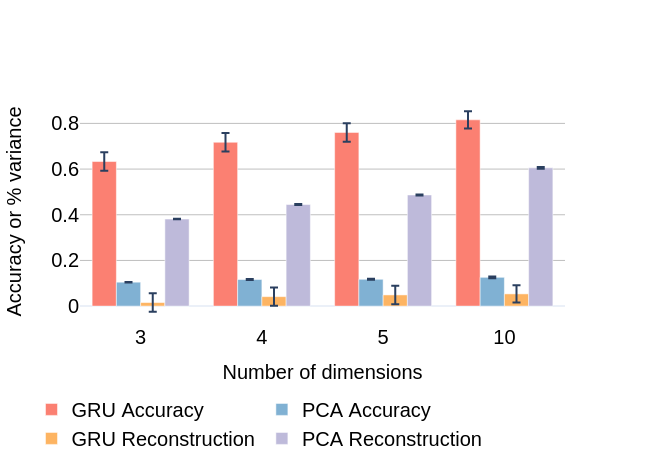

In [13]:
'''
variance
'''
r_pc = {}
PC_DIR = 'results/clip_pca'
for k_dim in args.dims:
    r_pc[k_dim] = _get_pc_results(PC_DIR, k_dim)
colors = px.colors.qualitative.Set3
#colors = ["#D55E00", "#009E73", "#56B4E9", "#E69F00"]
ss = 'var'
fig = _plot_fig_ext(ss)
fig.show()
fig.write_image('figures/fig3c.png')